In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm as cm
from astropy.table import Table
np.random.seed(42)
% matplotlib inline

In [2]:
# Read data
data = Table.read('../data/star_data.fits', format='fits')
sp_names = np.asarray(['CI', 'CH', 'OI', 'NaI', 'MgI', 'AlI', 'SiI', 'SI', 'CaI', 'ScI',
       'ScII', 'TiI', 'TiII', 'VI', 'CrI', 'CrII', 'MnI', 'CoI', 'NiI',
       'CuI', 'ZnI', 'SrI', 'YII', 'ZrII', 'BaII', 'LaII', 'CeII', 'PrII',
       'NdII', 'SmII', 'EuII', 'GdII', 'DyII'])
sp_err_names = np.asarray(["{}_err".format(spn) for spn in sp_names])

In [3]:
# Make plot labels
labels = np.asarray(["[ {} / Fe ]".format(spn) for spn in sp_names])
labels

array(['[ CI / Fe ]', '[ CH / Fe ]', '[ OI / Fe ]', '[ NaI / Fe ]',
       '[ MgI / Fe ]', '[ AlI / Fe ]', '[ SiI / Fe ]', '[ SI / Fe ]',
       '[ CaI / Fe ]', '[ ScI / Fe ]', '[ ScII / Fe ]', '[ TiI / Fe ]',
       '[ TiII / Fe ]', '[ VI / Fe ]', '[ CrI / Fe ]', '[ CrII / Fe ]',
       '[ MnI / Fe ]', '[ CoI / Fe ]', '[ NiI / Fe ]', '[ CuI / Fe ]',
       '[ ZnI / Fe ]', '[ SrI / Fe ]', '[ YII / Fe ]', '[ ZrII / Fe ]',
       '[ BaII / Fe ]', '[ LaII / Fe ]', '[ CeII / Fe ]', '[ PrII / Fe ]',
       '[ NdII / Fe ]', '[ SmII / Fe ]', '[ EuII / Fe ]', '[ GdII / Fe ]',
       '[ DyII / Fe ]'], 
      dtype='<U13')

In [4]:
# make rectangular data                                                                                          
N = len(data) # will be over-written
D = len(sp_names)
log_rectangle = np.zeros((N, D))
log_rectangle_err = np.zeros((N, D))
for d, (spn, spne) in enumerate(zip(sp_names, sp_err_names)):
    log_rectangle[:, d] = data[spn] # "log" b/c these are logarithmic abundances
    log_rectangle_err[:, d] = data[spne]

In [5]:
# FOR NOW: remove one bad object -- HACK
good = np.isfinite(log_rectangle)
bad = ~good
mask = np.sum(bad, axis=1) == 0
log_rectangle = log_rectangle[mask] # remove one star with one missing abundance
log_rectangle_err = log_rectangle_err[mask]
N, D = log_rectangle.shape # over-write

In [6]:
# make fake data with no structure
mean = np.mean(log_rectangle, axis=0)
log_rectangle_fake = mean[None, :] + np.random.normal(size=(N, D)) * log_rectangle_err

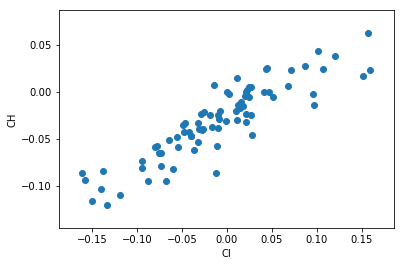

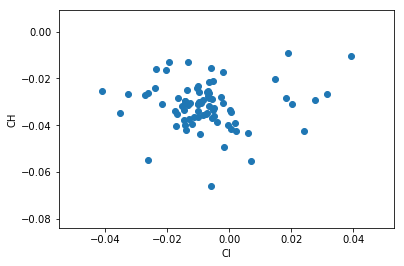

In [7]:
i, j = 0, 1
plt.scatter(log_rectangle[:, i], log_rectangle[:, j])
plt.xlabel(sp_names[i])
plt.ylabel(sp_names[j])
plt.figure()
plt.scatter(log_rectangle_fake[:, i], log_rectangle_fake[:, j])
plt.xlabel(sp_names[i])
plt.ylabel(sp_names[j])

In [8]:
def pca(data):
    mean = np.mean(data, axis=0)
    dd = data - mean[None, :]
    u, s, vecs = np.linalg.svd(dd, full_matrices=False)
    amps = u * s[None, :]
    # reconstrsyuction = mean[None, :] + np.dot(pcas, v)
    # print(data - reconstruction)
    return vecs, amps

(0.0001, 10.0)

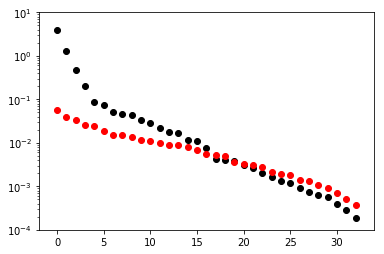

In [9]:
vecs, amps = pca(log_rectangle)
eigenvals = np.sum(amps * amps, axis=0)
plt.scatter(np.arange(len(eigenvals)), eigenvals, color="k")
fvecs, famps = pca(log_rectangle_fake)
feigenvals = np.sum(famps * famps, axis=0)
plt.scatter(np.arange(len(feigenvals)), feigenvals, color="r")
plt.semilogy()
plt.ylim(0.0001, 10.)

In [10]:
"""
linear_rectangle = np.power(10., log_rectangle) # taking off the logs
linear_rectangle_fake  = np.power(10., log_rectangle_fake) # taking off the logs
vecs, amps = pca(linear_rectangle)
eigenvals = np.sum(amps * amps, axis=0)
plt.scatter(np.arange(len(eigenvals)), eigenvals, color="k")
fvecs, famps = pca(linear_rectangle_fake)
feigenvals = np.sum(famps * famps, axis=0)
plt.scatter(np.arange(len(feigenvals)), feigenvals, color="r")
plt.semilogy()
plt.ylim(0.0005, 50.)
"""

'\nlinear_rectangle = np.power(10., log_rectangle) # taking off the logs\nlinear_rectangle_fake  = np.power(10., log_rectangle_fake) # taking off the logs\nvecs, amps = pca(linear_rectangle)\neigenvals = np.sum(amps * amps, axis=0)\nplt.scatter(np.arange(len(eigenvals)), eigenvals, color="k")\nfvecs, famps = pca(linear_rectangle_fake)\nfeigenvals = np.sum(famps * famps, axis=0)\nplt.scatter(np.arange(len(feigenvals)), feigenvals, color="r")\nplt.semilogy()\nplt.ylim(0.0005, 50.)\n'

In [11]:
# Make point properties
cmap = cm.get_cmap("viridis")
colors = np.arange(N)[::-1]

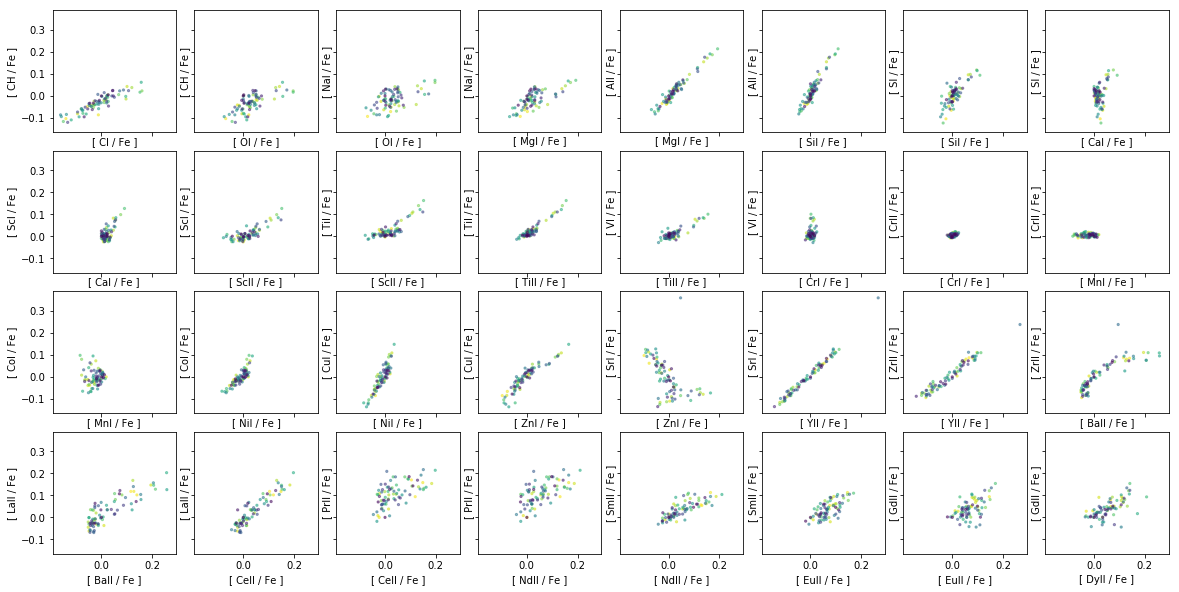

In [12]:
# Plot in the natural coordinates
s = 5.
alpha = 0.5
foo = 2.5
f, axlist = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(8 * foo, 4 * foo))
for i, ax in enumerate(axlist.flatten()):
    if (i + 1) >= D:
        break
    if i % 2:
        j, k = i+1, i
    else:
        j, k = i, i+1
    ax.scatter(log_rectangle[:, j], log_rectangle[:, k], s=s, c=colors, alpha=alpha, cmap=cmap)
    ax.set_xlabel(labels[j])
    ax.set_ylabel(labels[k])
f.subplots_adjust(hspace=0.15)
f.subplots_adjust(wspace=0.15)
# plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)

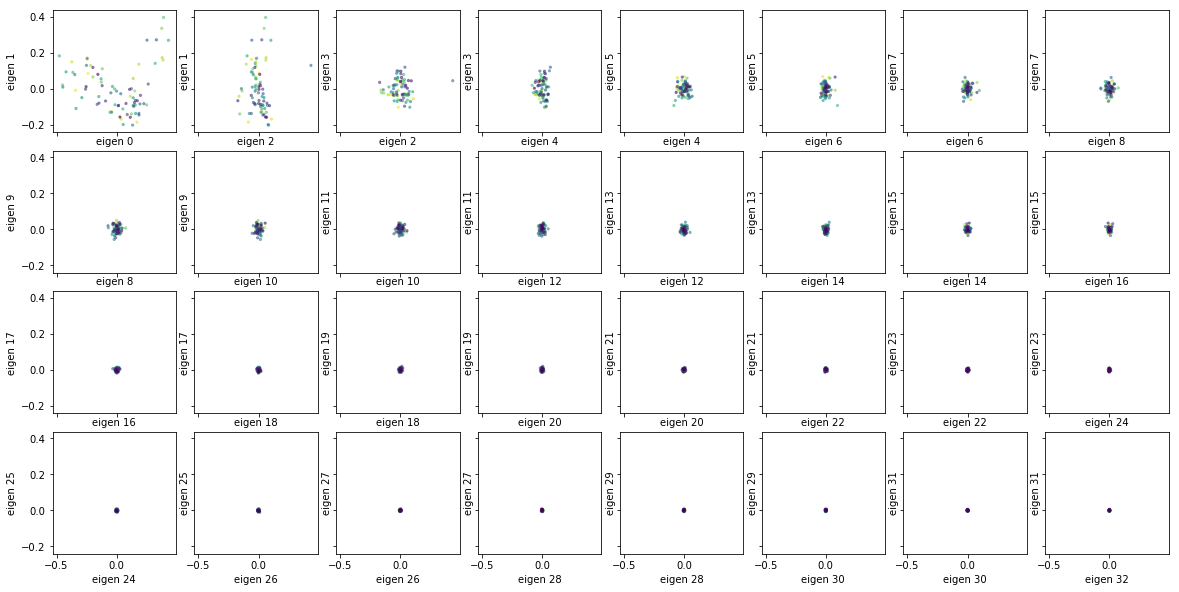

In [13]:
# Plot in the PCA coordinates
pca_labels = np.asarray(["eigen {}".format(d) for d in range(D)])
f, axlist = plt.subplots(4, 8, sharex=True, sharey=True, figsize=(8 * foo, 4 * foo))
for i, ax in enumerate(axlist.flatten()):
    if (i + 1) >= D:
        break
    if i % 2:
        j, k = i+1, i
    else:
        j, k = i, i+1
    ax.scatter(amps[:, j], amps[:, k], s=s, c=colors / N, alpha=alpha, cmap=cmap)
    ax.set_xlabel(pca_labels[j])
    ax.set_ylabel(pca_labels[k])
f.subplots_adjust(hspace=0.15)
f.subplots_adjust(wspace=0.15)